In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from keras.callbacks import EarlyStopping
from keras.models import Model
from sklearn.tree import DecisionTreeRegressor

In [2]:
def load_data(filename):
  return pd.read_csv(filename, usecols=range(0,7))

average_data = load_data("Well1_average_data.csv")
print(average_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5762 entries, 0 to 5761
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time [hrs]   5762 non-null   float64
 1   W_ga [kg/s]  5762 non-null   float64
 2   P_wf [bar]   5762 non-null   float64
 3   P_wh [bar]   5762 non-null   float64
 4   W_op [kg/s]  5762 non-null   float64
 5   W_gp [kg/s]  5762 non-null   float64
 6   W_lp [kg/s]  5762 non-null   float64
dtypes: float64(7)
memory usage: 315.2 KB
None


In [3]:
X = average_data[['W_ga [kg/s]', 'P_wf [bar]', 'P_wh [bar]']]
y = average_data[['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]']]
time = average_data['Time [hrs]']

std = StandardScaler()
X = std.fit_transform(X)

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into main set and test set
X_main, X_test, y_main, y_test = train_test_split(X, y, train_size=4033, shuffle=False)

# Split the main set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, train_size=2304, shuffle=False)

DT

In [5]:
dt_model = DecisionTreeRegressor(max_depth=1, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, max_features='sqrt')

In [6]:
DT_model = dt_model.predict(X)

GB

In [7]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model_t = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, loss='squared_error')
gb_model = MultiOutputRegressor(gb_model_t)


In [8]:
gb_model.fit(X_train, y_train)
GB_model = gb_model.predict(X)

XGB

In [9]:
from xgboost import XGBRegressor, DMatrix
Xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=7, learning_rate=0.01, random_state=42)
xgb = MultiOutputRegressor(Xgb_reg)

In [11]:
xgb.fit(X_train, y_train)
XGB_model = xgb.predict(X)


PLS

In [12]:
from sklearn.cross_decomposition import PLSRegression
pls_model = PLSRegression(n_components=1)
pls_model.fit(X_train, y_train)

PLSRegression(n_components=1)

In [13]:
PLS_model = pls_model.predict(X)

PCR

In [14]:
from sklearn.decomposition import PCA
pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=1)),
                ('linearregression', LinearRegression())])

In [15]:
PCR_model = pcr.predict(X)

In [16]:
def plot_flow_rates(actual_data, predicted_datas, time_data, flow_rates, model_labels):
    """
    Plots actual and predicted flow rates from given datasets.

    Parameters:
    - actual_data: The dataset containing the actual flow rates.
    - predicted_data: The dataset containing the predicted flow rates.
    - flow_rates: A list of flow rates to plot (e.g., ['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]']).
    """

    if not isinstance(time_data, pd.DataFrame):
        time_data = pd.DataFrame(time_data)

    actual_data = actual_data.merge(time_data, left_index=True, right_index=True)

    fig, ax = plt.subplots(figsize=(14, 4))
    fig.suptitle("Prediction by multiple models")
    plt.axvline(x=67.21, linestyle=':', color='black')
    #adding text inside the plot
    plt.text(30, 88, 'Training data', fontsize = 10, bbox = dict(boxstyle='round', facecolor ='green', alpha=0.3))
    plt.text(80, 88, 'Testing data', fontsize = 10, bbox = dict(boxstyle='round', facecolor ='green', alpha=0.3))

    #plt.text(45, 80, 'Training data', fontsize = 10, bbox = dict(boxstyle='round', facecolor ='green', alpha=0.3))
    #plt.text(80, 80, 'Testing data', fontsize = 10, bbox = dict(boxstyle='round', facecolor ='green', alpha=0.3))
    actual_color = "black"
    colors = ["red", "green", "blue", "orange", "purple"] # Colors for the flow rates
    line_styles = ["-", "--"] # Line styles for actual and predicted data

    for i, flow_rate in enumerate(flow_rates):
        # Plot actual flow rates
        ax.plot(
            actual_data['Time [hrs]'], actual_data[flow_rate],
            line_styles[0],
            label=f"Actual {flow_rate}",
            color=actual_color
        )

        for j, predicted_data in enumerate(predicted_datas):
            label_text = f"Predicted {flow_rate}"
            if j < len(model_labels):
                label_text = f"{model_labels[j]} {label_text}"           
            ax.plot(
                actual_data['Time [hrs]'], predicted_data[flow_rate],
                line_styles[1],
                label=f"{model_labels[j]} Predicted {flow_rate}",
                color=colors[j % len(colors)]
            )

    ax.set_xlabel('Time [hrs]')
    ax.set_ylabel('Flow Rate [kg/s]')

    #_ = ax.legend(loc='lower left', fontsize=8)
    _ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

    plt.show()

# Example usage
flow_rates_to_plot = ['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]']
model_labels = ["DT", "GB", "XGB", "PLS", "PCR"]

In [18]:
DT_predictions = pd.DataFrame(DT_model, columns=['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]'])
GB_predictions = pd.DataFrame(GB_model, columns=['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]'])
XGB_predictions = pd.DataFrame(XGB_model, columns=['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]'])
PLS_predictions = pd.DataFrame(PLS_model, columns=['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]'])
PCR_predictions = pd.DataFrame(PCR_model, columns=['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]'])

In [19]:
predicted_datas7 = [DT_predictions, GB_predictions, XGB_predictions, PLS_predictions, PCR_predictions]

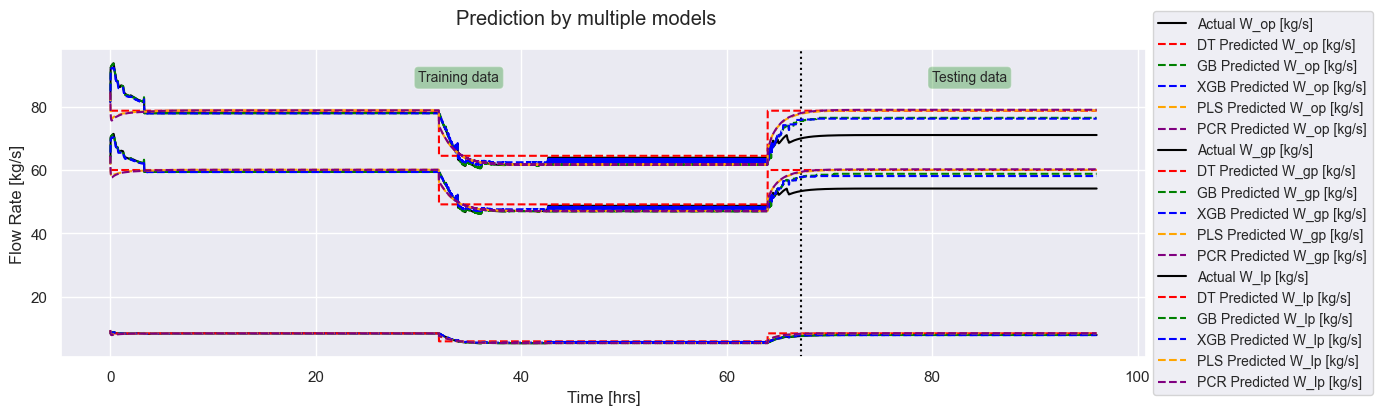

In [20]:
plot_flow_rates(y, predicted_datas7, time, flow_rates_to_plot, model_labels)